In [18]:
import pandas as pd

In [19]:
df = pd.read_csv('data.csv')

In [20]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib as plt
import seaborn as sns

In [22]:
# Drop id column and encode diagnosis
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis'].map({'M': 1, 'B': 0})

In [23]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [24]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
# Train XGBoost model
model = xgb.XGBClassifier(
    learning_rate=0.01,
    n_estimators=200,
    max_depth=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [26]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [27]:
# Evaluate model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        67
           1       0.98      0.94      0.96        47

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


In [28]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Important Features:")
print(importance_df.head())


Top 5 Important Features:
                 feature  importance
7    concave points_mean    0.241216
22       perimeter_worst    0.181556
27  concave points_worst    0.155799
20          radius_worst    0.069744
23            area_worst    0.057086


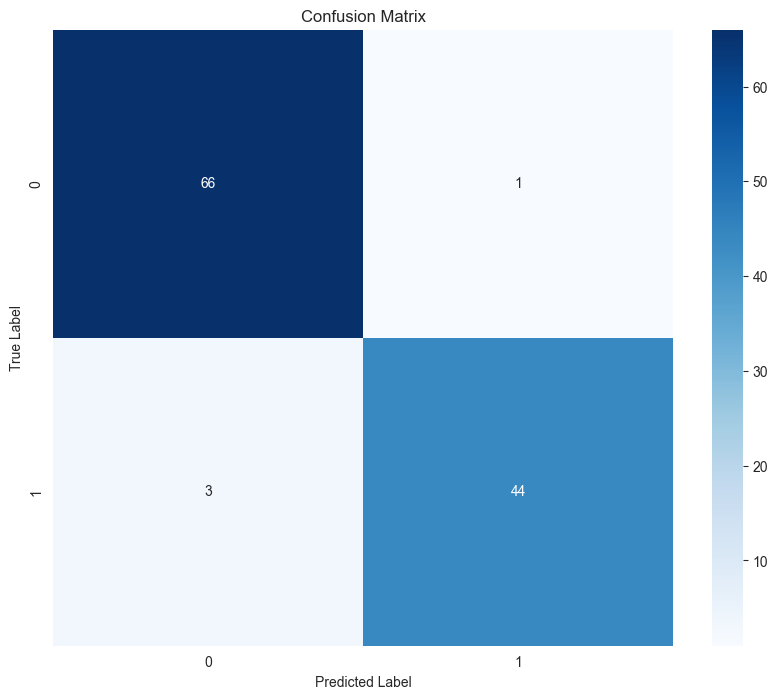

In [31]:
import matplotlib.pyplot as plt
# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [32]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, r2_score

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cross_val_scores = cross_validate(model, X, y, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])

In [37]:
results = {
            "model": "XGBoost",
            "R2": r2,
            "RMSE": rmse,
            "Cross Validation R2": cross_val_scores['test_r2'].mean(),
            "Cross Validation RMSE": np.mean(-cross_val_scores['test_neg_root_mean_squared_error'])
        }
        
results

{'model': 'XGBoost',
 'R2': 0.8551921244839632,
 'RMSE': 0.1873171623163388,
 'Cross Validation R2': 0.8125364590644641,
 'Cross Validation RMSE': 0.20229621787341956}

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score
import numpy as np

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)

# For classification, we'll use different cross-validation scoring metrics
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

results = {
    "model": "XGBoost",
    "Accuracy": accuracy_score(y_test, y_pred),
    "MAE": mae,
    "Cross Validation Accuracy": cv_scores.mean(),
    "Cross Validation Std": cv_scores.std()
}

# Create a formatted display of results with interpretations
print("Model Performance Metrics:\n")
print(f"1. Accuracy:")
print(f"   - Test set: {results['Accuracy']:.3f}")
print(f"   - Cross-validation: {results['Cross Validation Accuracy']:.3f} (±{results['Cross Validation Std']:.3f})")
print(f"   Interpretation: The model correctly classifies {results['Accuracy']*100:.1f}% of the cases.\n")

print(f"2. Mean Absolute Error (MAE):")
print(f"   - Test set: {results['MAE']:.3f}")
print(f"   Interpretation: On average, the predicted probabilities deviate by {results['MAE']:.3f} from the true labels.\n")

print("Cross-validation Analysis:")
print(f"- The model achieves {results['Cross Validation Accuracy']*100:.1f}% accuracy across different data splits")
print(f"- Standard deviation of {results['Cross Validation Std']:.3f} indicates model stability")

# Additional context for binary classification
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nAdditional Classification Metrics:")
print(f"- Precision: {precision:.3f} (accuracy of positive predictions)")
print(f"- Recall: {recall:.3f} (fraction of positives correctly identified)")
print(f"- F1 Score: {f1:.3f} (harmonic mean of precision and recall)")

results  # Return the dictionary of results

Model Performance Metrics:

1. Accuracy:
   - Test set: 0.965
   - Cross-validation: 0.956 (±0.023)
   Interpretation: The model correctly classifies 96.5% of the cases.

2. Mean Absolute Error (MAE):
   - Test set: 0.035
   Interpretation: On average, the predicted probabilities deviate by 0.035 from the true labels.

Cross-validation Analysis:
- The model achieves 95.6% accuracy across different data splits
- Standard deviation of 0.023 indicates model stability

Additional Classification Metrics:
- Precision: 0.978 (accuracy of positive predictions)
- Recall: 0.936 (fraction of positives correctly identified)
- F1 Score: 0.957 (harmonic mean of precision and recall)


{'model': 'XGBoost',
 'Accuracy': 0.9649122807017544,
 'MAE': 0.03508771929824561,
 'Cross Validation Accuracy': 0.9560937742586555,
 'Cross Validation Std': 0.02283883380490945}